In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import plotly.graph_objs as go
from itertools import combinations
import ast
from scipy.stats import linregress
import community.community_louvain as community_louvain


from pokegraph import *

G, df, node_data = Pokegraph('pokedata.csv', hr = True, cutoff=1100, validate=True)
winrates, average_ratings, playrates = node_data

c:\Users\Nutzer\Documents\Studies\pokeproject\venv\Lib\site-packages\numba\core\utils.py:621: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
c:\Users\Nutzer\Documents\Studies\pokeproject\venv\Lib\site-packages\bicm\models_functions.py:326: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  step_fun = args[0]
c:\Users\Nutzer\Documents\Studies\pokeproject\venv\Lib\site-packages\bicm\models_functions.py:327: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  arg_step_fun = args[1]
c:\Users\Nutzer\Documents\Studies\pokeproject\venv\Lib\site-packages\numba\core\utils.py:621: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


max rows error = 1.880113842389619e-09
max columns error = 3.353376200720959e-06
total error = 9.975640933745922e-06
Solver converged.


100%|██████████| 425/425 [00:01<00:00, 351.76it/s]


### This script is for the explorative analysis of data scraped from PokemonShowdowns Replay API


This data is based on the PokemonShowdown competitive Pokemon website. I analyze the main battle format (Overused / OU). Pokemon usually appear in teams of 6 with no duplicates but mirror matches are possible.
 I.e Charizard cannot appear twice on your team, but it can appear once on your team and once on your opponents team. I pull battle logs to extract Teamcompositions, Rating, and Winners of every battle.

Please Note: 
The data is not a random sample but shared via replays. This will lead to oversampliming of more "gimmicky" Pokemon due to players willingness to share more "interesting" battles. To keep this bias as low as possible we can filter by usage and rating statistics.

The raw data is turned to a dataframe where each row corresponds to one battle. From this dataframe I construct a raph where Pokemon share edges if they appear on the same team.

Node-Properties for a Node A:

- Winrate (# Wins(A) / # Appearances(A) )
- Playrate (# Appearances(A) / # Total Teams)
- Rating average (mean rating of all the battles including A)

Edge-Properties for Edge (A,B)
- Cooccurance (# Shared teams of (A,B) )  [Undirected]
- Cooccurance Winrate (# Shared wins (A,B) / Cooccurance(A,B) ) [Undirected]

- Conditional occurance (Cooccurance(A,B) / # Appearances(A) ) [Directed A --> B]

### First glance

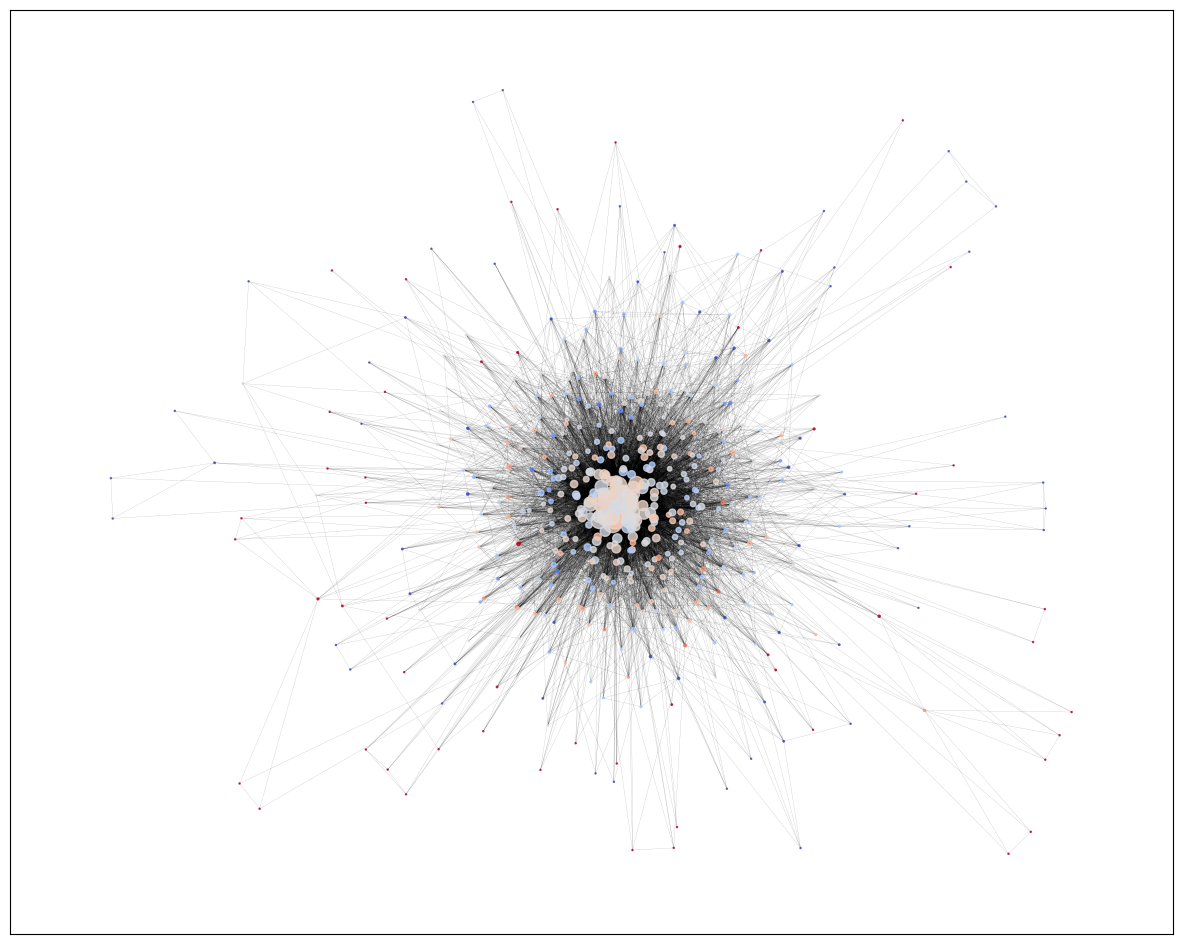

In [ ]:
G_full, df_full, node_data_full = Pokegraph('pokedata.csv', hr = False, cutoff=1100, validate=False)
winrates_full, average_ratings_full, playrates_full = node_data_full
node_colors = [(winrates_full[node]) for node in G_full.nodes]
node_size = [(playrates_full[node]*2000) for node in G_full.nodes]


plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G_full)
nodes = nx.draw_networkx_nodes(G_full, pos=pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=node_size, alpha=0.8)
edges = nx.draw_networkx_edges(G_full, pos=pos, alpha = 0.5, width=0.1)

### Identifying main component after validation / filtering

In [14]:
[print(len(c)) for c in nx.connected_components(G)]
print('Largest component:',len(nx.node_connected_component(G, "Great Tusk"))) # highest playrate pokemon

2
171
3
4
2
2
2
4
5
3
2
2
3
3
2
4
2
3
4
2
3
Largest component: 171


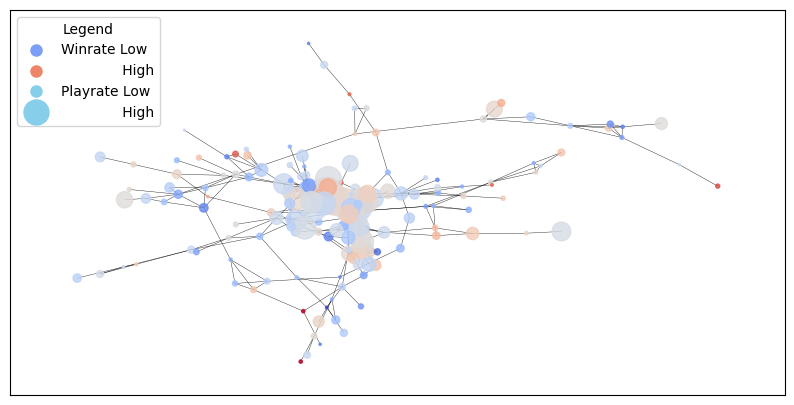

In [ ]:
main = G.subgraph(nx.node_connected_component(G, "Great Tusk"))
subgraph = G
node_colors = [(winrates[node]) for node in main.nodes]
node_size = [(playrates[node]*2500) for node in main.nodes]
plt.figure(figsize=(10, 5))
pos = nx.spring_layout(main, seed=2)
nodes = nx.draw_networkx_nodes(main, pos=pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=node_size, alpha=0.8)
edges = nx.draw_networkx_edges(main, pos=pos, edge_color='black', alpha = 0.9, width=0.3)
node_color_legend = mlines.Line2D([], [], color=plt.cm.coolwarm(0.2), marker='o', markersize=8, linestyle='None', label='Winrate Low')
node_color_legend2 = mlines.Line2D([], [], color=plt.cm.coolwarm(0.8), marker='o', markersize=8, linestyle='None', label='              High')

# Node Size Legend (Playrate)
small_node = mlines.Line2D([], [], color='skyblue', marker='o', markersize=8, linestyle='None', label='Playrate Low')
large_node = mlines.Line2D([], [], color='skyblue', marker='o', markersize=18, linestyle='None', label='              High')

# Add legend
plt.legend(handles=[node_color_legend, node_color_legend2, small_node, large_node],
           loc='upper left', fontsize=10, title="Legend")

# Part 1) Descriptive Analysis

### Distribution of node statistics:

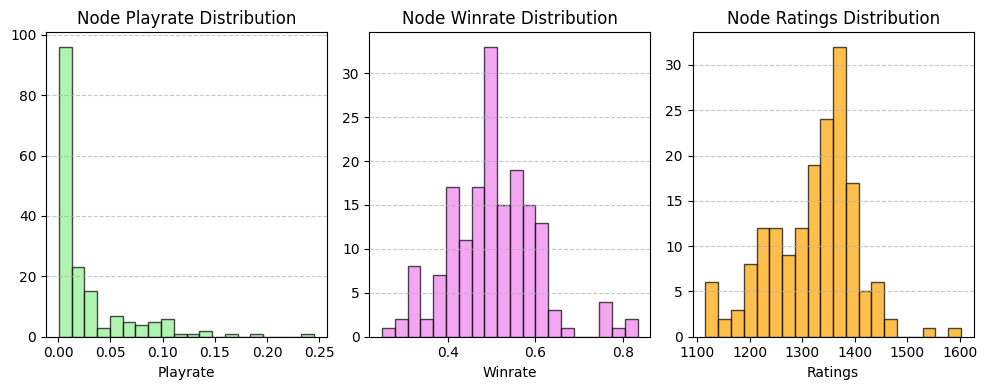

In [15]:

playrates_list = [data['playrate'] for _, data in subgraph.nodes(data=True)]
playrate_counts, playrate_bins = np.histogram(playrates_list, bins=20)

winrates_list = [data['winrate'] for _, data in subgraph.nodes(data=True)]
winrates_counts, winrates_bins = np.histogram(winrates_list, bins=20)

ratings_list = [data['rating_avg'] for _, data in subgraph.nodes(data=True) if data['rating_avg'] > 0] # Ignore 0 ratings (NAs)
ratings_counts, ratings_bins = np.histogram(ratings_list, bins=20) 

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=False)

# Plot Node Playrate Distribution
axes[0].bar(playrate_bins[:-1], playrate_counts, width=(playrate_bins[1] - playrate_bins[0]),
            color='lightgreen', alpha=0.7, edgecolor='black', align='edge')
axes[0].set_title('Node Playrate Distribution')
axes[0].set_xlabel('Playrate')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Node Winrate Distribution
axes[1].bar(winrates_bins[:-1], winrates_counts, width=(winrates_bins[1] - winrates_bins[0]),
            color='violet', alpha=0.7, edgecolor='black', align='edge')
axes[1].set_title('Node Winrate Distribution')
axes[1].set_xlabel('Winrate')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Node Rating Distribution
axes[2].bar(ratings_bins[:-1], ratings_counts, width=(ratings_bins[1] - ratings_bins[0]),
            color='orange', alpha=0.7, edgecolor='black', align='edge')
axes[2].set_title('Node Ratings Distribution')
axes[2].set_xlabel('Ratings')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Distribution of edge statistics:

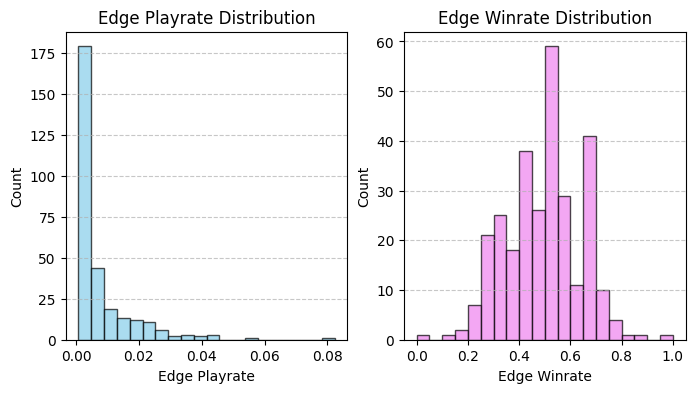

In [16]:
edge_playrates = [data['edge_playrate'] for _, _, data in subgraph.edges(data=True)]
weight_counts, weight_bins = np.histogram(edge_playrates, bins=20)

edge_winrates = [data['conditional_winrate'] for _, _, data in subgraph.edges(data=True)]
edge_winrates_counts, edge_winrates_bins = np.histogram(edge_winrates, bins=20)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

# Plot Edge Weight Distribution
axes[0].bar(weight_bins[:-1], weight_counts, width=(weight_bins[1] - weight_bins[0]),
            color='skyblue', alpha=0.7, edgecolor='black', align='edge')
axes[0].set_title('Edge Playrate Distribution')
axes[0].set_xlabel('Edge Playrate')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot Edge Winrate Distribution
axes[1].bar(edge_winrates_bins[:-1], edge_winrates_counts, width=(edge_winrates_bins[1] - edge_winrates_bins[0]),
            color='violet', alpha=0.7, edgecolor='black', align='edge')
axes[1].set_title('Edge Winrate Distribution')
axes[1].set_xlabel('Edge Winrate')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)


### Degree Analysis

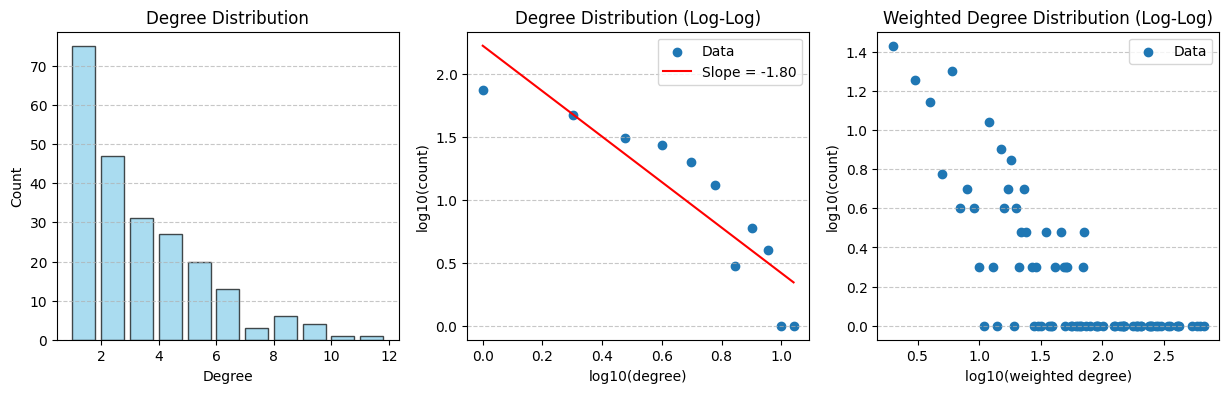

In [43]:
# Degree Dist
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

# Degree Dist (log-log)
degrees_log = [deg for _, deg in G.degree()]
degree_counts = np.bincount(degrees_log)
nonzero = degree_counts > 0
x = np.arange(len(degree_counts))[nonzero]
y = degree_counts[nonzero]
log_x = np.log10(x)
log_y = np.log10(y)

slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y) # Fit line

# Degree Dist (weighted)
degree_sequence_weighted = sorted((d for n, d in G.degree(weight='weight')), reverse=True)
degrees_weighted, counts_weighted = np.unique(degree_sequence_weighted, return_counts=True)
nonzero_w = counts_weighted > 0
log_degrees_w = np.log10(degrees_weighted[nonzero_w])
log_counts_w = np.log10(counts_weighted[nonzero_w])


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

axes[0].bar(*np.unique(degree_sequence, return_counts=True),
            color='skyblue', alpha=0.7, edgecolor='black', align='edge')
axes[0].set_title('Degree Distribution')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].scatter(log_x, log_y, label="Data")
axes[1].plot(log_x, intercept + slope * log_x, color="red", label=f"Slope = {slope:.2f}")
axes[1].set_xlabel("log10(degree)")
axes[1].set_ylabel("log10(count)")
axes[1].set_title("Degree Distribution (Log-Log)")
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

axes[2].scatter(log_degrees_w, log_counts_w, label="Data")
axes[2].set_xlabel("log10(weighted degree)")
axes[2].set_ylabel("log10(count)")
axes[2].set_title("Weighted Degree Distribution (Log-Log)")
axes[2].legend()
axes[2].grid(axis='y', linestyle='--', alpha=0.7)


### Centrality Analysis

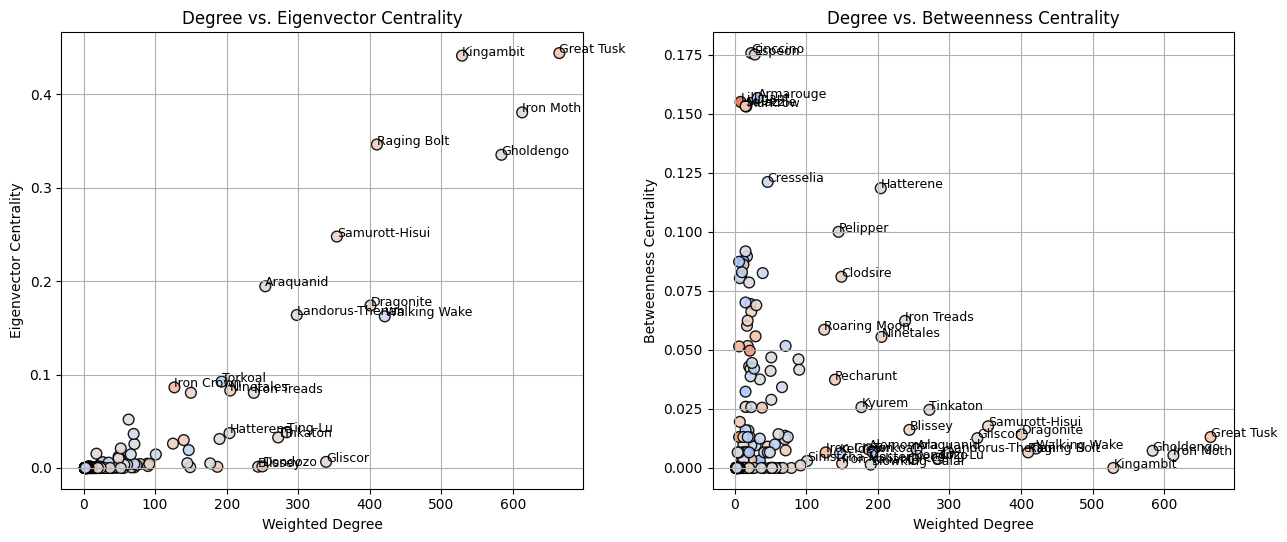

In [44]:

# Compute centralities and weighted degree
weighted_degree = dict(G.degree(weight='weight'))
eigen_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)

nodes = list(G.nodes())
x = [weighted_degree[n] for n in nodes]
y_eigen = [eigen_centrality[n] for n in nodes]
y_between = [betweenness[n] for n in nodes]

node_colors = [winrates[node] for node in G.nodes]

vmin = min(node_colors)  
vmax = max(node_colors)  

cmap = plt.cm.coolwarm  
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(13, 6), sharex=False)

# Plot 1: Eigenvector Centrality
axs[0].scatter(x, y_eigen, alpha=0.9, edgecolors='black', s=60, c=node_colors,cmap=cmap, norm=norm)
for i in range(len(x)):
    if y_eigen[i] > 0.085 or x[i] > 200:
        axs[0].text(x[i], y_eigen[i], nodes[i], fontsize=9)
axs[0].set_xlabel("Weighted Degree")
axs[0].set_ylabel("Eigenvector Centrality")
axs[0].set_title("Degree vs. Eigenvector Centrality")
axs[0].grid(True)

# Plot 2: Betweenness Centrality
axs[1].scatter(x, y_between, alpha=0.9, edgecolors='black', s=60, c=node_colors,cmap=cmap, norm=norm)
for i in range(len(x)):
    if y_between[i] > 0.1 or x[i] > 100:
        axs[1].text(x[i], y_between[i], nodes[i], fontsize=9)
axs[1].set_xlabel("Weighted Degree")
axs[1].set_ylabel("Betweenness Centrality")
axs[1].set_title("Degree vs. Betweenness Centrality")
axs[1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

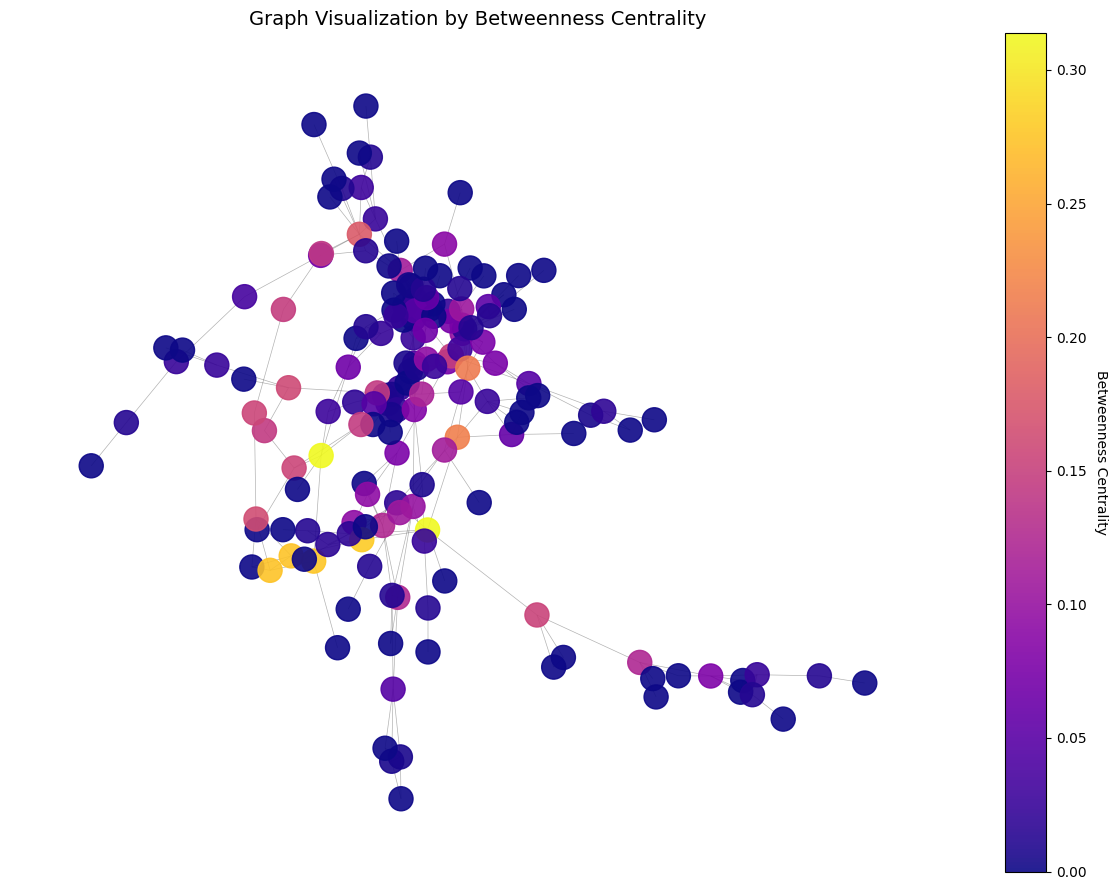

In [46]:
main_inv = main.copy()
for u, v, d in main_inv.edges(data=True):
    d['inv_weight'] = 1 / d['weight'] if d['weight'] != 0 else float('inf')
betweenness = nx.betweenness_centrality(main, weight='weight', normalized=True)
max_centrality = max(betweenness.values())
#node_sizes = [5000 * (betweenness[n] / max_centrality) for n in main.nodes()]  # scale size
node_colors = [betweenness[n] for n in main.nodes()]  # color intensity

pos = nx.spring_layout(main, weight='weight', seed=1)  # Use spring layout
plt.figure(figsize=(12, 9))
nodes = nx.draw_networkx_nodes(main, pos,
    #node_size=node_sizes,
    node_color=node_colors,
    cmap='plasma', alpha=0.9)
nx.draw_networkx_edges(main, pos, alpha=0.3, width=0.5)

# Colorbar
cbar = plt.colorbar(nodes)
cbar.set_label('Betweenness Centrality', rotation=270, labelpad=15)

plt.title("Graph Visualization by Betweenness Centrality", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

### Winrate Analysis

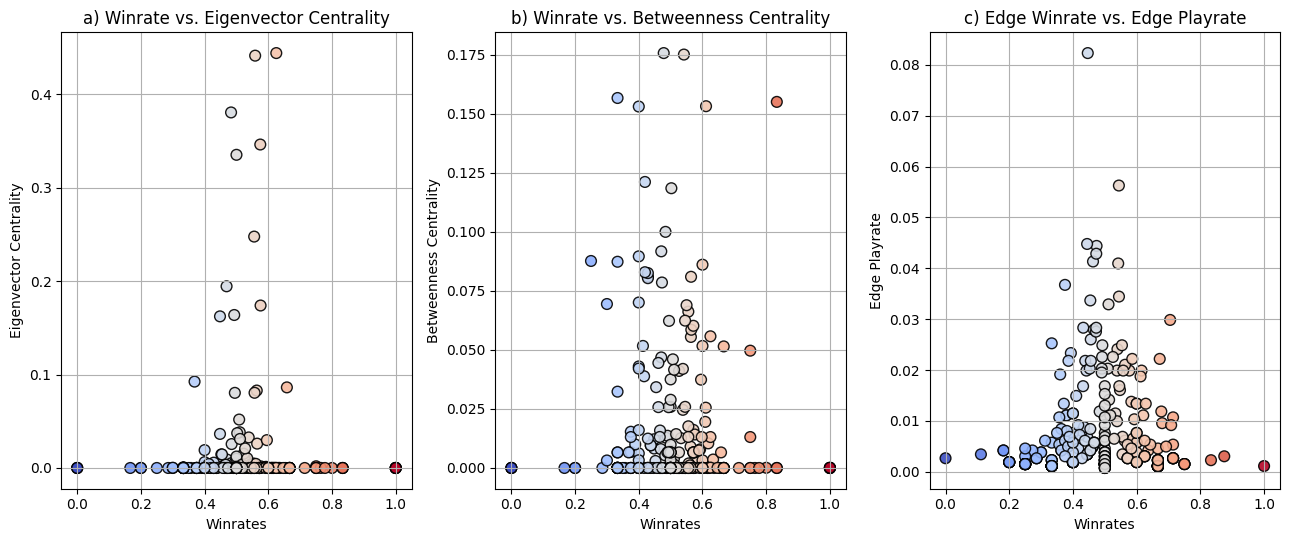

In [45]:



eigen_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)

# Prepare data
nodes = list(G.nodes())
x = [winrates[n] for n in nodes]
y_eigen = [eigen_centrality[n] for n in nodes]
y_between = [betweenness[n] for n in nodes]

edge_winrates = [data['conditional_winrate'] for _, _, data in subgraph.edges(data=True)]
edge_playrates = [data['edge_playrate'] for _, _, data in subgraph.edges(data=True)]
edge_colors = edge_winrates

node_colors = [winrates[node] for node in G.nodes]
vmin = min(node_colors) 
vmax = max(node_colors)  

cmap = plt.cm.coolwarm  
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

#  Create subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 6), sharex=False)

#  Plot 1: Eigenvector Centrality
axs[0].scatter(x, y_eigen, alpha=0.9, edgecolors='black', s=60, c=node_colors,cmap=cmap, norm=norm)
axs[0].set_xlabel("Winrates")
axs[0].set_ylabel("Eigenvector Centrality")
axs[0].set_title("a) Winrate vs. Eigenvector Centrality")
axs[0].grid(True)

#  Plot 2: Betweenness Centrality
axs[1].scatter(x, y_between, alpha=0.9, edgecolors='black', s=60, c=node_colors,cmap=cmap, norm=norm)
axs[1].set_xlabel("Winrates")
axs[1].set_ylabel("Betweenness Centrality")
axs[1].set_title("b) Winrate vs. Betweenness Centrality")
axs[1].grid(True)

# Plot 3: Edge winrate
axs[2].scatter(edge_winrates, edge_playrates, alpha=0.9, edgecolors='black', s=60, c = edge_colors, cmap=cmap)
axs[2].set_xlabel("Winrates")
axs[2].set_ylabel("Edge Playrate")
axs[2].set_title("c) Edge Winrate vs. Edge Playrate")
axs[2].grid(True)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Part 2) Community Analysis

In [48]:
# Color by partition
partition = community_louvain.best_partition(subgraph, weight='weight')
pos = nx.spring_layout(subgraph, seed=2)
unique_communities = sorted(set(partition.values()))
palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
community_colors = {comm: palette[i % len(palette)] for i, comm in enumerate(unique_communities)}

edge_x = []
edge_y = []
for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines',
    showlegend=False
)

# --- Per-Community Node Traces ---
node_traces = []
for comm in unique_communities:
    node_x = []
    node_y = []
    node_text = []

    for node in subgraph.nodes():
        if partition[node] == comm:
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(f"{node} - Community {comm}")

    trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode='markers',
        name=f'Community {comm}',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            color=community_colors[comm],
            size=10,
            line_width=2
        )
    )
    node_traces.append(trace)

# --- Combine and Plot ---
fig = go.Figure(
    data=[edge_trace] + node_traces,
    layout=go.Layout(
        title=dict(
            text="Community Detection with Legend",
            font=dict(size=16)
        ),
        showlegend=True,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        height = 1200,
        width = 1500,
        annotations=[
            dict(
                text=" ",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002
            )
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

fig.show()


### Voting-based ranking from player-community

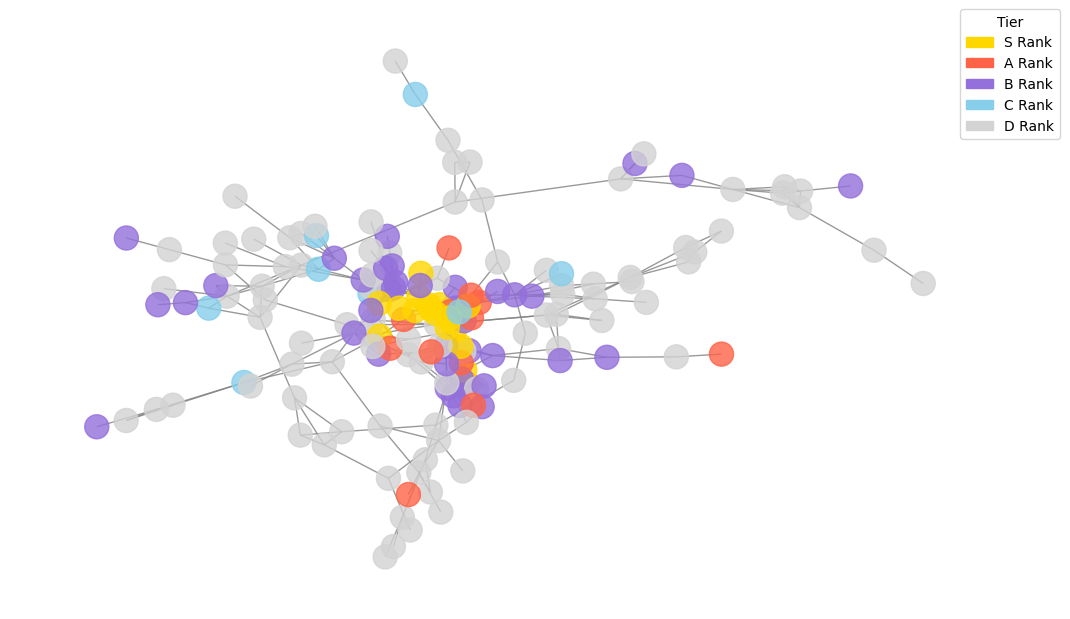

In [49]:
from matplotlib.patches import Patch

tier_mapping = {
    # S Rank
    "Zamazenta-*": "S Rank",
    "Gliscor": "S Rank",
    "Great Tusk": "S Rank",
    "Kingambit": "S Rank",
    "Ting-Lu": "S Rank",

    # A+ Rank
    "Darkrai": "A+ Rank",
    "Dragapult": "A+ Rank",
    "Dragonite": "A+ Rank",
    "Gholdengo": "A+ Rank",
    "Iron Valiant": "A+ Rank",
    "Kyurem": "A+ Rank",
    "Landorus-Therian": "A+ Rank",
    "Ogerpon-Wellspring": "A+ Rank",
    "Pecharunt": "A+ Rank",
    "Raging Bolt": "A+ Rank",
    "Roaring Moon": "A+ Rank",
    "Samurott-Hisui": "A+ Rank",

    # A Rank
    "Cinderace": "A Rank",
    "Garganacl": "A Rank",
    "Iron Moth": "A Rank",
    "Moltres": "A Rank",
    "Slowking-Galar": "A Rank",
    "Zapdos": "A Rank",

    # A- Rank
    "Alomomola": "A- Rank",
    "Clefable": "A- Rank",
    "Corviknight": "A- Rank",
    "Deoxys-Speed": "A- Rank",
    "Iron Treads": "A- Rank",
    "Lokix": "A- Rank",
    "Primarina": "A- Rank",
    "Tinkaton": "A- Rank",
    "Weavile": "A- Rank",

    # B+ Rank
    "Enamorus": "B+ Rank",
    "Glimmora": "B+ Rank",
    "Hatterene": "B+ Rank",
    "Hydrapple": "B+ Rank",
    "Iron Crown": "B+ Rank",
    "Keldeo": "B+ Rank",
    "Latios": "B+ Rank",
    "Ninetales-Alola": "B+ Rank",
    "Scizor": "B+ Rank",
    "Sinistcha": "B+ Rank",
    "Tornadus-Therian": "B+ Rank",
    "Ursaluna": "B+ Rank",
    "Walking Wake": "B+ Rank",
    "Weezing-Galar": "B+ Rank",

    # B Rank
    "Araquanid": "B Rank",
    "Clodsire": "B Rank",
    "Dondozo": "B Rank",
    "Garchomp": "B Rank",
    "Greninja": "B Rank",
    "Hawlucha": "B Rank",
    "Hoopa-Unbound": "B Rank",
    "Manaphy": "B Rank",
    "Meowscarada": "B Rank",
    "Ninetales": "B Rank",
    "Ogerpon": "B Rank",
    "Ogerpon-Cornerstone": "B Rank",
    "Okidogi": "B Rank",
    "Rillaboom": "B Rank",
    "Rotom-Wash": "B Rank",
    "Serperior": "B Rank",
    "Slither Wing": "B Rank",
    "Skarmory": "B Rank",
    "Torkoal": "B Rank",
    "Toxapex": "B Rank",
    "Volcanion": "B Rank",

    # B- Rank
    "Amoonguss": "B- Rank",
    "Barraskewda": "B- Rank",
    "Blaziken": "B- Rank",
    "Blissey": "B- Rank",
    "Excadrill": "B- Rank",
    "Heatran": "B- Rank",
    "Hydreigon": "B- Rank",
    "Iron Boulder": "B- Rank",
    "Iron Hands": "B- Rank",
    "Latias": "B- Rank",
    "Moltres-Galar": "B- Rank",
    "Pelipper": "B- Rank",
    "Ribombee": "B- Rank",
    "Skeledirge": "B- Rank",
    "Tyranitar": "B- Rank",
    "Venusaur": "B- Rank",

    # C+ Rank
    "Ceruledge": "C+ Rank",
    "Cresselia": "C+ Rank",
    "Enamorus-Therian": "C+ Rank",
    "Fezandipiti": "C+ Rank",
    "Goodra-Hisui": "C+ Rank",
    "Kommo-o": "C+ Rank",
    "Lilligant-Hisui": "C+ Rank",
    "Reuniclus": "C+ Rank",
    "Thundurus-Therian": "C+ Rank",

    # C Rank
    "Chansey": "C Rank",
    "Comfey": "C Rank",
    "Grimmsnarl": "C Rank",
    "Mamoswine": "C Rank",
    "Mandibuzz": "C Rank",
    "Maushold": "C Rank",
    "Overqwil": "C Rank",
    "Polteageist": "C Rank",

    # D Rank
    "Arcanine-Hisui": "D Rank",
    "Armarouge": "D Rank",
    "Azumarill": "D Rank",
    "Basculegion": "D Rank",
    "Bellibolt": "D Rank",
    "Breloom": "D Rank",
    "Bronzong": "D Rank",
    "Chesnaught": "D Rank",
    "Cyclizar": "D Rank",
    "Diancie": "D Rank",
    "Entei": "D Rank",
    "Indeedee": "D Rank",
    "Iron Jugulis": "D Rank",
    "Kingdra": "D Rank",
    "Leavanny": "D Rank",
    "Mimikyu": "D Rank",
    "Necrozma": "D Rank",
    "Quagsire": "D Rank",
    "Quaquaval": "D Rank",
    "Sandy Shocks": "D Rank",
    "Scream Tail": "D Rank",
    "Talonflame": "D Rank",
}

tier_colors = {
    "S Rank": "#FFD700",        # Gold
    "A+ Rank": "#FFD700",       
    "A Rank": "#FF6347",        # Tomato
    "A- Rank": "#FF6347",       # 
    "B Rank": "#9370DB",       # Medium Purple
    "B+ Rank": "#9370DB",        # 
    "B- Rank": "#9370DB",       # 
    "C Rank": "#87CEEB",       # Sky Blue
    "C+ Rank": "#87CEEB",        # 
    "D Rank": "#D3D3D3",        # Light Gray
    "unranked": "#D3D3D3"       # 
}



node_colors = []
for node in main.nodes:
    rank = tier_mapping.get(node, "unranked")
    color = tier_colors.get(rank, "#D3D3D3")
    node_colors.append(color)

unique_legend_items = {}
for rank, color in tier_colors.items():
    if color not in unique_legend_items.values():
        unique_legend_items[rank] = color
legend_handles = [Patch(color=color, label=rank) for rank, color in unique_legend_items.items()]

# Make legend handles
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(main, seed=2)  # Layout algorithm
nx.draw(main, pos, node_color=node_colors, edge_color='gray', alpha = 0.8)
plt.legend(handles=legend_handles, title="Tier", loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Show plot
plt.show()


### Manually  found communities by playstyle

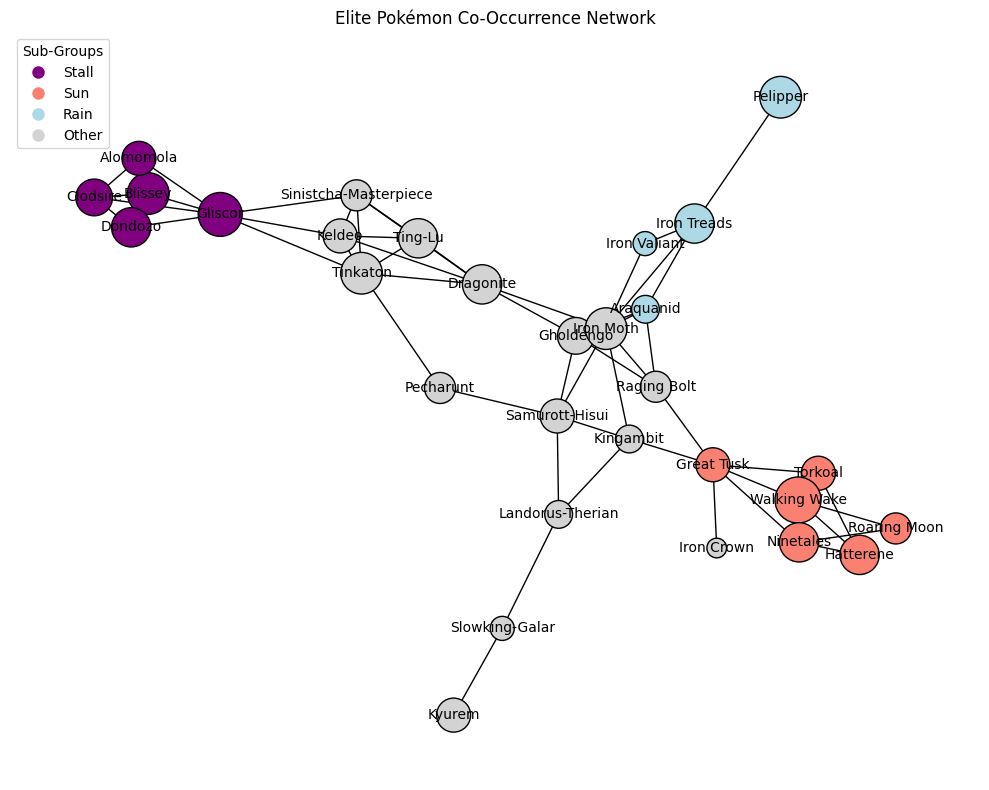

In [51]:
# Sort nodes by degree
degree_dict = dict(G.degree(weight='weight'))
sorted_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

# Top 10 elites
top_elites = sorted_degrees[:30]
elite_names = [mon for mon, _ in top_elites]

# Manually defined sub-group (e.g., Stall core, Offensive core)
subgroup_dict = {
    'Blissey': 'Stall',
    'Gliscor': 'Stall',
    'Alomomola': 'Stall',
    'Clodsire': 'Stall',
    'Dondozo': 'Stall',

    'Torkoal': 'Sun',
    'Ninetales': 'Sun',
    'Walking Wake': 'Sun',
    'Hatterene': 'Sun',
    'Roaring Moon': 'Sun',
    'Great Tusk': 'Sun',

    'Pelipper': 'Rain',
    'Araquanid': 'Rain',
    'Iron Treads': 'Rain',
    'Iron Valiant': 'Rain',

}

group_colors = {
    'Stall': 'purple',
    'Sun': 'salmon',
    'Rain': 'Lightblue',
    'Other': 'lightgray'
}
elite_subgraph = G.subgraph(elite_names)

# Assign color to each node based on group
node_colors = []
for node in elite_subgraph.nodes():
    group = subgroup_dict.get(node, 'Other')
    node_colors.append(group_colors[group])




plt.figure(figsize=(10, 8))
pos = nx.spring_layout(elite_subgraph, seed=6)

node_sizes = [G.degree(n) * 100 for n in elite_subgraph.nodes()]
nx.draw_networkx_nodes(elite_subgraph, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')

edge_weights = [elite_subgraph[u][v]['weight'] for u, v in elite_subgraph.edges()]
nx.draw_networkx_edges(elite_subgraph, pos)#, edge_color=[w * 0.2 for w in edge_weights], alpha=0.7)

# Labels
nx.draw_networkx_labels(elite_subgraph, pos, font_size=10)

handles = [plt.Line2D([0], [0], marker='o', color='w', label=grp,
                      markerfacecolor=clr, markersize=10)
           for grp, clr in group_colors.items()]
plt.legend(handles=handles, title="Sub-Groups", loc='upper left')

plt.title("Elite Pokémon Co-Occurrence Network")
plt.axis('off')
plt.tight_layout()
plt.show()

# Part 3) Interactive Analysis

### Meta-Game graph of main component:

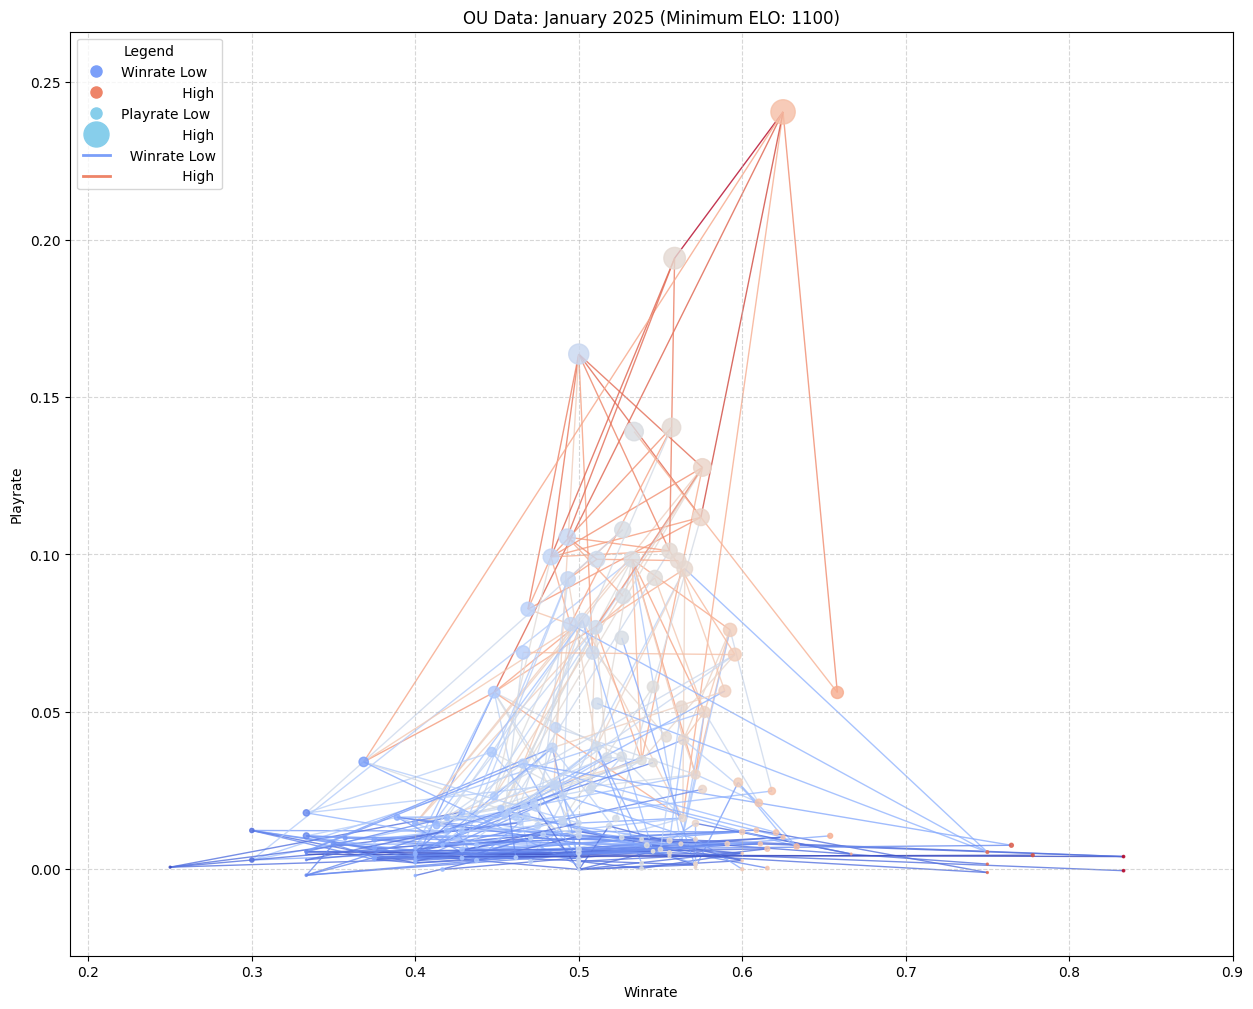

In [19]:
node_colors = [winrates[node] for node in main.nodes]
node_size = [playrates[node]*1250 for node in main.nodes]

edge_colors = [np.log(main[u][v]['weight']) for u, v in main.edges]

plt.figure(figsize=(15, 12))
pos = {node: (data['winrate'], data['playrate']+ np.random.uniform(-0.005, 0.005) ) for node, data in main.nodes(data=True)}

nodes = nx.draw_networkx_nodes(main, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=node_size, alpha=0.8)
#labels = nx.draw_networkx_labels(subgraph, pos, font_size=10, font_color='black')

edges = nx.draw_networkx_edges(main, pos, edge_color=edge_colors, edge_cmap=plt.cm.coolwarm, alpha = 0.8)

plt.xlabel("Winrate")
plt.ylabel("Playrate")
plt.grid(True, linestyle='--', alpha=0.5)  # Optional grid
plt.xticks(np.linspace(0.2,0.9, num  = 8))
plt.yticks(np.linspace(0,0.25, num  = 6))
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.title(label='OU Data: January 2025 (Minimum ELO: 1100)')

node_color_legend = mlines.Line2D([], [], color=plt.cm.coolwarm(0.2), marker='o', markersize=8, linestyle='None', label='Winrate Low')
node_color_legend2 = mlines.Line2D([], [], color=plt.cm.coolwarm(0.8), marker='o', markersize=8, linestyle='None', label='              High')

# Node Size Legend (Playrate)
small_node = mlines.Line2D([], [], color='skyblue', marker='o', markersize=8, linestyle='None', label='Playrate Low')
large_node = mlines.Line2D([], [], color='skyblue', marker='o', markersize=18, linestyle='None', label='              High')

# Edge Color Legend (Co-occurrence)
low_edge = mlines.Line2D([], [], color=plt.cm.coolwarm(0.2), linewidth=2, label='  Winrate Low')
high_edge = mlines.Line2D([], [], color=plt.cm.coolwarm(0.8), linewidth=2, label='              High')

# Add legend
plt.legend(handles=[node_color_legend, node_color_legend2, small_node, large_node, low_edge, high_edge],
           loc='upper left', fontsize=10, title="Legend")

## Interactive meta-graph

In [28]:

pos = {
    node: (data['winrate'], data['playrate'] + np.random.uniform(-0.005, 0.005))
    for node, data in main.nodes(data=True)
}

node_x = []
node_y = []
node_text = []
node_size = []
node_colors = []

for node in main.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(node)  # Hover text
    node_size.append(playrates[node]*300)
    node_colors.append(winrates[node])

# Edge trace
edge_x = []
edge_y = []
edge_colors = []

for u, v in main.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_colors.append(np.log(main[u][v]['weight']))

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=1, color='rgba(150,150,150,0.5)'),
    hoverinfo='none'
)

# Node trace
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    marker=dict(
        showscale=True,
        colorscale='RdBu_r',
        color=node_colors,
        size=node_size,
        colorbar=dict(
            thickness=15,
            title='Winrate',
            xanchor='left',
            titleside='right'
        ),
        line_width=2
    ),
    text=node_text,
    hoverinfo='text'
)

# Create figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='OU Data: January 2025 (Minimum ELO: 1100)',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        width = 1500,
        height = 1200,
        xaxis=dict(title='Winrate', tickvals=np.linspace(0.2, 0.9, 8), gridcolor='lightgray'),
        yaxis=dict(title='Playrate', tickvals=np.linspace(0, 0.25, 6), gridcolor='lightgray'),
        plot_bgcolor='white'
    )
)

fig.show()


### Partnerplot

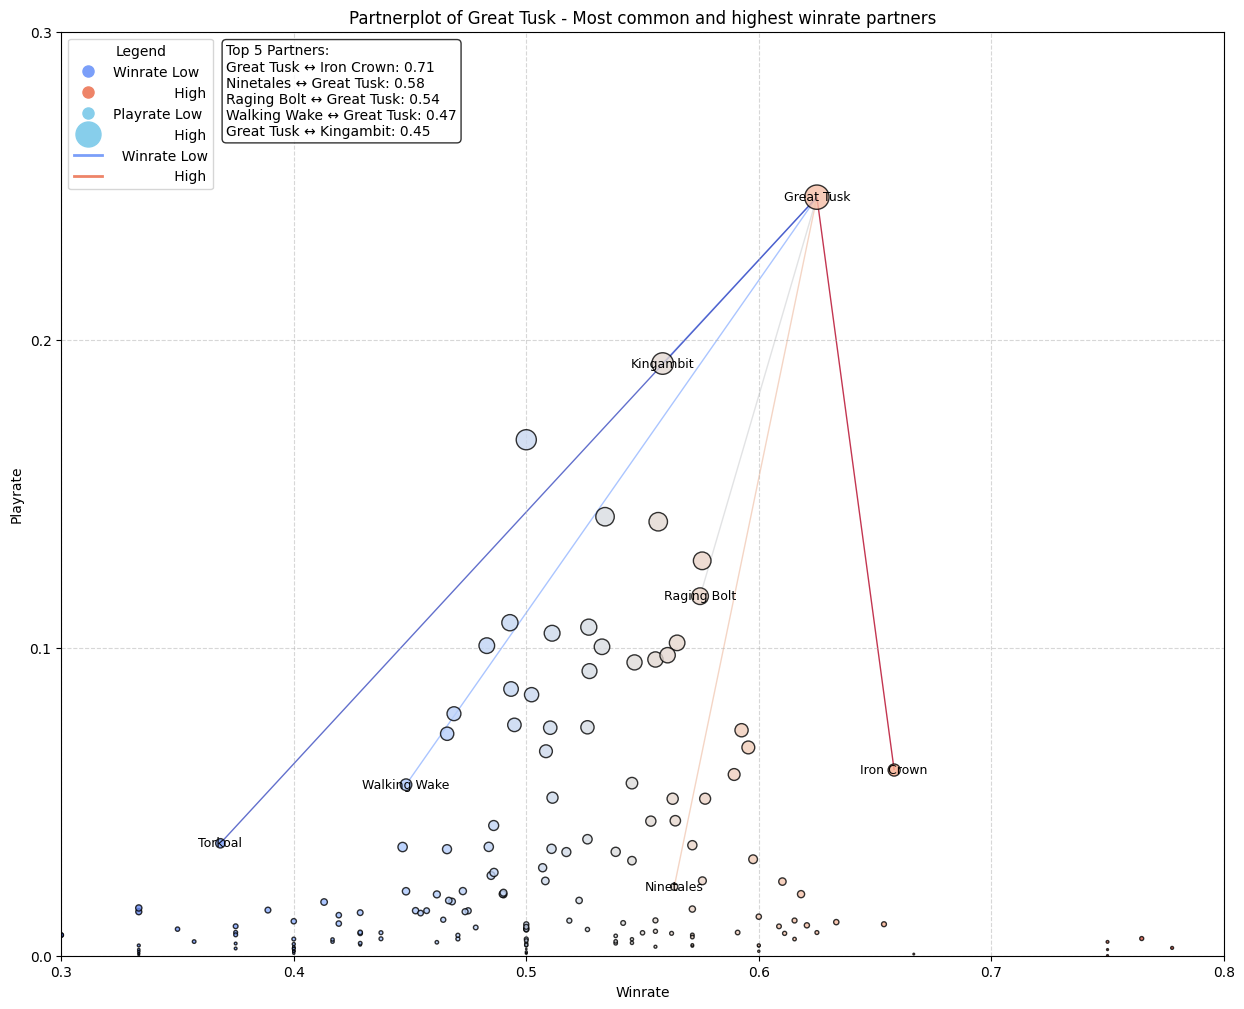

In [ ]:
def partnerplot(subgraph, ego=None):    

    plt.figure(figsize=(15, 12))
    pos = {node: (data['winrate'], data['playrate'] + np.random.uniform(-0.0015, 0.0015)) for node, data in subgraph.nodes(data=True)}


        # Node attributes
    node_colors = [winrates[node] for node in subgraph.nodes]
    node_size = [playrates[node] * 1250 for node in subgraph.nodes]
        
    if ego != None:
        # Filter edges and sort by 'conditional_winrate'
        filtered_edges = [(u, v) for u, v in subgraph.edges if (ego in (u, v))]
        filtered_edges_sorted = sorted(filtered_edges, key=lambda edge: subgraph[edge[0]][edge[1]]['conditional_winrate'], reverse=True)
        top_5_edges = filtered_edges_sorted[:5]
        
        # Edge attributes
        edge_colors = [subgraph[u][v]['conditional_winrate'] for u, v in filtered_edges]
        filtered_nodes = {u for u, v in filtered_edges} | {v for u, v in filtered_edges}
        labels = nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in filtered_nodes}, font_size=9, font_color='black')
        edges = nx.draw_networkx_edges(subgraph, pos, edgelist=filtered_edges, edge_color=edge_colors, edge_cmap=plt.cm.coolwarm, alpha=0.8)
        nodes = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=node_size, alpha=0.8, edgecolors='black')
            # Display top 5 edges in a separate box
        top_5_text = '\n'.join([f'{u} ↔ {v}: {subgraph[u][v]["conditional_winrate"]:.2f}' for u, v in top_5_edges])
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        plt.text(0.235, 0.87, f'Top 5 Partners:\n{top_5_text}', fontsize=10, bbox=props, transform=plt.gcf().transFigure, verticalalignment='top')
        plt.title(label=f'Partnerplot of {ego} - Most common and highest winrate partners')


  
    else: 
        labels = nx.draw_networkx_labels(subgraph, pos, labels={node: node for node in subgraph.nodes}, font_size=9, font_color='black')
        nodes = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, cmap=plt.cm.coolwarm, node_size=node_size, alpha=0.8, edgecolors='black')
        plt.title(label='Winrate and Playrate of OU Pokemon')


    
    # Plot annotations
    plt.xlabel("Winrate")
    plt.ylabel("Playrate")
    plt.xlim(0.3, 0.8)
    plt.ylim(0, 0.3)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(np.linspace(0.3,0.8, num  = 6))
    plt.yticks(np.linspace(0,0.3, num  = 4))
    plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    # Legend setup
    node_color_legend = mlines.Line2D([], [], color=plt.cm.coolwarm(0.2), marker='o', markersize=8, linestyle='None', label='Winrate Low')
    node_color_legend2 = mlines.Line2D([], [], color=plt.cm.coolwarm(0.8), marker='o', markersize=8, linestyle='None', label='              High')
    small_node = mlines.Line2D([], [], color='skyblue', marker='o', markersize=8, linestyle='None', label='Playrate Low')
    large_node = mlines.Line2D([], [], color='skyblue', marker='o', markersize=18, linestyle='None', label='              High')
    low_edge = mlines.Line2D([], [], color=plt.cm.coolwarm(0.2), linewidth=2, label='  Winrate Low')
    high_edge = mlines.Line2D([], [], color=plt.cm.coolwarm(0.8), linewidth=2, label='              High')
    
    plt.legend(handles=[node_color_legend, node_color_legend2, small_node, large_node, low_edge, high_edge],
               loc='upper left', fontsize=10, title="Legend")
    

    
    plt.show()

partnerplot(subgraph, 'Great Tusk')

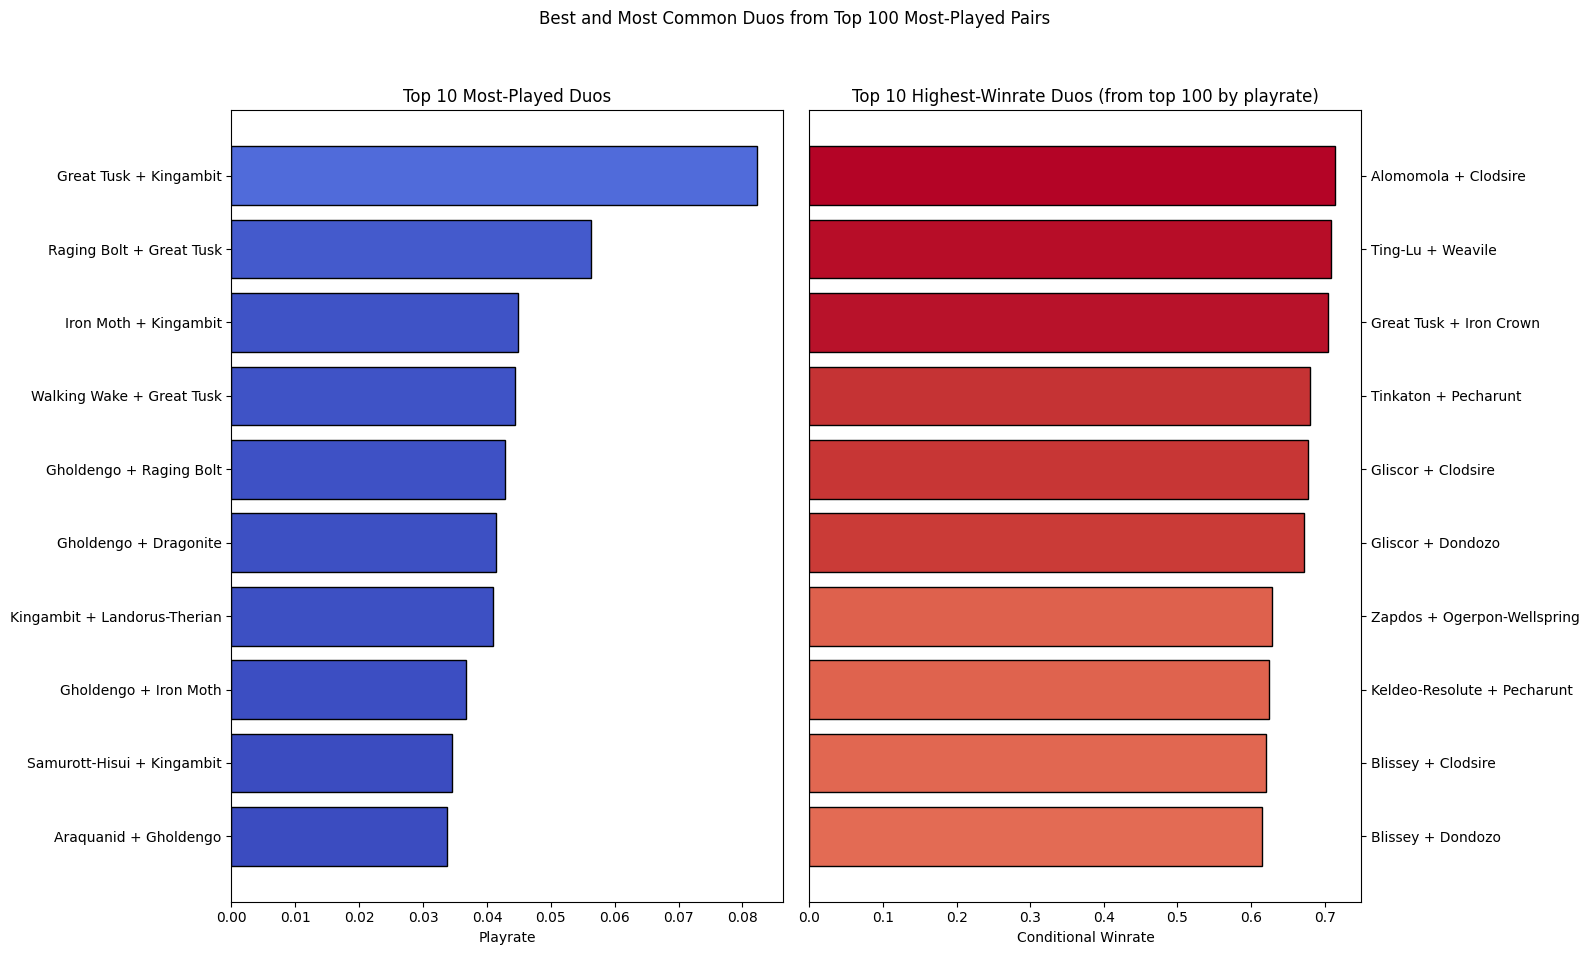

In [42]:
def plot_top_edges(subgraph, n):
    # Get top N edges by playrate
    top_playrate_edges = sorted(
        subgraph.edges(data=True),
        key=lambda edge: edge[2].get('edge_playrate', 0),
        reverse=True
    )[:n]

    # Top 10 by playrate
    top_10_playrate_edges = top_playrate_edges[:10]
    playrate_labels = [f"{u} + {v}" for u, v, _ in top_10_playrate_edges]
    playrate_values = [data['edge_playrate'] for _, _, data in top_10_playrate_edges]

    # Top 10 winrate edges in top N playrate edges
    top_winrate_from_top_playrate = sorted(
        top_playrate_edges,
        key=lambda edge: edge[2].get('conditional_winrate', 0),
        reverse=True
    )[:10]
    winrate_labels = [f"{u} + {v}" for u, v, _ in top_winrate_from_top_playrate]
    winrate_values = [data['conditional_winrate'] for _, _, data in top_winrate_from_top_playrate]

    #  color normalization
    all_values = playrate_values + winrate_values
    norm = plt.Normalize(min(all_values), max(all_values))
    colormap = plt.cm.coolwarm

    playrate_colors = [colormap(norm(v)) for v in playrate_values]
    winrate_colors = [colormap(norm(v)) for v in winrate_values]

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 10))
    fig.suptitle(f'Best and Most Common Duos from Top {n} Most-Played Pairs')

    y_pos = np.arange(10)

    # Left: Most-played duos
    axes[0].barh(y_pos, playrate_values, color=playrate_colors, edgecolor='black')
    axes[0].set_yticks(y_pos)
    axes[0].set_yticklabels(playrate_labels)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Playrate')
    axes[0].set_title('Top 10 Most-Played Duos')

    # Right: Best winrate duos from that group
    axes[1].barh(y_pos, winrate_values, color=winrate_colors, edgecolor='black')
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(winrate_labels)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Conditional Winrate')
    axes[1].set_title(f'Top 10 Highest-Winrate Duos (from top {n} by playrate)')
    axes[1].yaxis.set_label_position("right")
    axes[1].yaxis.tick_right()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_top_edges(subgraph, 100)

# Part 4) Validation

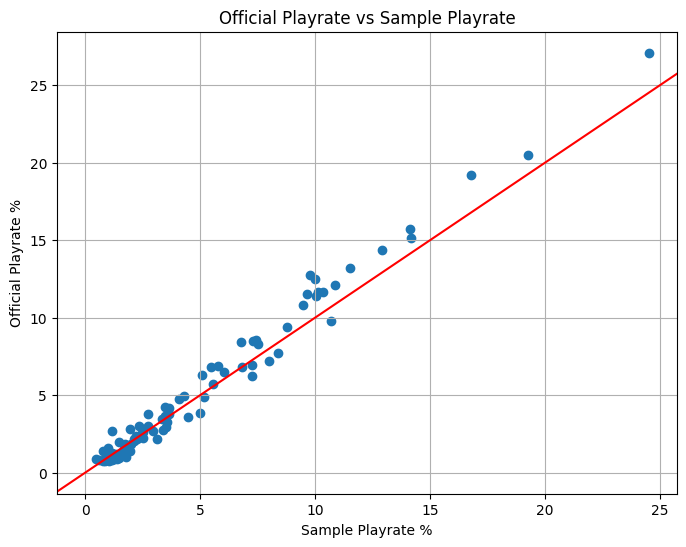

In [ ]:

data = {  
    "Pokemon": ["Great Tusk", "Kingambit", "Gholdengo", "Dragapult", "Iron Valiant", "Dragonite", "Raging Bolt", "Ogerpon-Wellspring", 
                "Gliscor", "Landorus-Therian", "Iron Moth", "Slowking-Galar", "Samurott-Hisui", "Roaring Moon", "Zamazenta", "Corviknight", 
                "Cinderace", "Kyurem", "Ting-Lu", "Darkrai", "Glimmora", "Iron Treads", "Hatterene", "Meowscarada", "Araquanid", "Primarina", 
                "Zapdos", "Rillaboom", "Pecharunt", "Iron Crown", "Garganacl", "Moltres", "Alomomola", "Walking Wake", "Enamorus", "Garchomp", 
                "Clefable", "Scizor", "Tinkaton", "Ceruledge", "Dondozo", "Serperior", "Sinistcha", "Torkoal", "Blissey", "Clodsire", "Weavile", 
                "Pelipper", "Toxapex", "Heatran", "Blaziken", "Ninetales-Alola", "Rotom-Wash", "Lokix", "Ursaluna", "Keldeo", "Skeledirge", 
                "Greninja", "Ribombee", "Tyranitar", "Deoxys-Speed", "Excadrill", "Hydrapple", "Hoopa-Unbound", "Ninetales", "Quaquaval", 
                "Weezing-Galar", "Skarmory", "Iron Hands", "Latias", "Palafin", "Ogerpon-Cornerstone", "Hawlucha", "Grimmsnarl", "Maushold", 
                "Latios", "Gengar", "Venusaur", "Goodra-Hisui", "Arcanine-Hisui", "Amoonguss", "Barraskewda", "Mimikyu", "Okidogi", "Metagross", 
                "Azumarill", "Kommo-o", "Volcanion", "Thundurus-Therian", "Zoroark-Hisui", "Galvantula", "Hydreigon", "Incineroar", "Talonflame", 
                "Espeon", "Iron Boulder", "Mandibuzz", "Ogerpon", "Comfey", "Armarouge", "Mamoswine", "Cloyster", "Haxorus", "Reuniclus", 
                "Umbreon", "Gyarados", "Indeedee", "Cresselia", "Manaphy", "Polteageist", "Charizard", "Moltres-Galar", "Tornadus-Therian", 
                "Blastoise", "Gardevoir", "Slowking", "Sandy Shocks", "Kleavor", "Feraligatr", "Salamence"],
    "Usage %": [27.08423, 20.47314, 19.20289, 15.73770, 15.13451, 14.36406, 13.21546, 12.77369, 12.48344, 12.07364, 11.67916, 11.62330, 
                11.52359, 11.42163, 10.88055, 10.81912, 9.80471, 9.37089, 8.58650, 8.47331, 8.46070, 8.32160, 7.73999, 7.35670, 7.23430, 
                6.92421, 6.89835, 6.80877, 6.78815, 6.48087, 6.39704, 6.28541, 6.23811, 5.72413, 4.93661, 4.86488, 4.77244, 4.27576, 4.24678, 
                4.14996, 3.87388, 3.87227, 3.76731, 3.76276, 3.64616, 3.61455, 3.46731, 3.25100, 3.02042, 3.01826, 2.97841, 2.92743, 2.78943, 
                2.78773, 2.73813, 2.69110, 2.67242, 2.66497, 2.61500, 2.54179, 2.38281, 2.26842, 2.17239, 2.16807, 2.14294, 2.10761, 2.03412, 
                1.96437, 1.84404, 1.83705, 1.78303, 1.76154, 1.73273, 1.58954, 1.57587, 1.55135, 1.51974, 1.44708, 1.42269, 1.40608, 1.40185, 
                1.37268, 1.34797, 1.30228, 1.30085, 1.27839, 1.26795, 1.23206, 1.15462, 1.14307, 1.12973, 1.12655, 1.08270, 1.06379, 1.03379, 
                1.01621, 1.00678, 0.96661, 0.94392, 0.92161, 0.90150, 0.89087, 0.88493, 0.88144, 0.87987, 0.87748, 0.87568, 0.87131, 0.85783, 
                0.84941, 0.84311, 0.82829, 0.81283, 0.79916, 0.79847, 0.79056, 0.78462, 0.78218, 0.77712, 0.77321],
}

usage_dict = dict(zip(data["Pokemon"], data["Usage %"]))

smogon_playrate = []
sample_playrate = []
names = []

for node in G.nodes:
    if node in usage_dict and 'playrate' in G.nodes[node]:
        smogon_playrate.append(usage_dict[node])
        sample_playrate.append(G.nodes[node]['playrate']*100)
        names.append(node)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(sample_playrate, smogon_playrate)
plt.axline(xy1=(0,0),slope=1, color ="red")
plt.xlabel("Sample Playrate %")
plt.ylabel("Official Playrate %")
plt.title("Official Playrate vs Sample Playrate")
plt.grid(True)